# Training eines neuronalen Netzes
- Ziel: Testen eines einfachen neuronalen Netzes zur Vorhersage der AQI_NO2-Werte  
- Features: die auch vorher verwendeten Features bei der Vorhersage von AQI_No2 mit GBC (Kalender ohne Monate,Meterologische Features ohne Strahlung und Druck, Konzentrationen der anderen Schadstoffe)
- Für das neuronale Netz wird tensorflow.keras verwendet, welches in diesem Bereich üblicher ist als sklearn (da z.B. auch GPU Unterstützung)

In [1]:
#Import 
import pandas as pd
#import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection as model_selection
from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import metrics

aqi_labels={0:"Good",1:"Fair",2:"Moderate",3:"Poor"}

2023-01-25 14:20:31.635861: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Datenvorbereitung

In [32]:
#Laden der Df
predictor_neural_network = pd.read_hdf("Predictor_Data/neural_network_data.h5").drop(['month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12'],axis=1)
predictor_neural_network.columns

Index(['day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7',
       'businness_day', 'PRCP', 'TMAX', 'TMIN', 'AWND', 'WSF2', 't_minmax',
       'mean_temp', 'max_value_temp', 'mean_humidity', 'max_value_humidity',
       'wind_north', 'wind_south', 'wind_east', 'wind_west', 'mean_co',
       'max_value_co', 'mean_so2', 'max_value_so2', 'mean_no2',
       'max_value_no2', 'mean_o3', 'max_value_o3', 'mean_pm2_5', 'aqi_pm2_5',
       'aqi_so2', 'aqi_no2', 'aqi_o3', 'aqi_max'],
      dtype='object')

In [34]:
'Drop unncessacary columns and dropna rows'
predictor_neural_network=predictor_neural_network.drop([ 'aqi_pm2_5',
       'aqi_so2', 'aqi_o3', 'aqi_max', 'mean_no2',"max_value_no2"],axis=1)
all_data=predictor_neural_network.dropna()
all_data["aqi_no2"].value_counts()

Fair              3145
Moderate          1108
Poor               531
Good               372
Very Poor           18
Extremely Poor       0
Name: aqi_no2, dtype: int64

In [35]:
'drop rows with Very Poor AQI NO2'
all_data=all_data[all_data["aqi_no2"] != "Very Poor"]

In [36]:

X = all_data.drop("aqi_no2",axis=1)
X[X.columns] = MinMaxScaler().fit_transform(X)
y = all_data["aqi_no2"].cat.codes
X_train,X_test,y_train,y_test= model_selection.train_test_split(X,y)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3867 entries, 2015-12-24 to 2018-11-24
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   day_1               3867 non-null   float64
 1   day_2               3867 non-null   float64
 2   day_3               3867 non-null   float64
 3   day_4               3867 non-null   float64
 4   day_5               3867 non-null   float64
 5   day_6               3867 non-null   float64
 6   day_7               3867 non-null   float64
 7   businness_day       3867 non-null   float64
 8   PRCP                3867 non-null   float64
 9   TMAX                3867 non-null   float64
 10  TMIN                3867 non-null   float64
 11  AWND                3867 non-null   float64
 12  WSF2                3867 non-null   float64
 13  t_minmax            3867 non-null   float64
 14  mean_temp           3867 non-null   float64
 15  max_value_temp      3867 non-null   f

In [37]:
y_train.value_counts()

1    2365
2     829
3     393
0     280
dtype: int64

## Quellen: 
[Sequential Model](https://www.tensorflow.org/guide/keras/sequential_model#setup), 
[Example with Classification](https://www.tensorflow.org/tutorials/keras/classification), 
[API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)

## Erläuterungen zur Auswahl einiger Komponenten

- 'SparseCategoricalCrossentropy' scheint für diesen Fall hier gut geeignet zu sein, da mehrere kategorische Labels unterstützt werden.
- 'relu' ist eine häufig gewählte Aktivierungsfunktion: $ f(x) = max(0,x)$ 
- He initializer der Gewichte [analyticsvidhya](https://www.analyticsvidhya.com/blog/2021/09/a-comprehensive-guide-on-neural-networks-performance-optimization/)

In [64]:
'create the neural Network'
initializer = tf.keras.initializers.HeNormal(seed=3)
model = keras.Sequential()
#Input Layer
model.add(keras.Input(shape=(29,)))

for i in range(4):
    model.add(layers.Dense(60,activation="relu",name=f"hidden_layer_{i}",kernel_initializer=initializer))

model.add(layers.Dense(50,activation="relu",name=f"hidden_layer_-3",kernel_initializer=initializer))
model.add(layers.Dense(50,activation="relu",name=f"hidden_layer_-2",kernel_initializer=initializer))
#Output Layer
model.add(layers.Dense(4,activation="softmax",name="output_layer"))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_0 (Dense)      (None, 60)                1800      
                                                                 
 hidden_layer_1 (Dense)      (None, 60)                3660      
                                                                 
 hidden_layer_2 (Dense)      (None, 60)                3660      
                                                                 
 hidden_layer_3 (Dense)      (None, 60)                3660      
                                                                 
 hidden_layer_-3 (Dense)     (None, 50)                3050      
                                                                 
 hidden_layer_-2 (Dense)     (None, 50)                2550      
                                                                 
 output_layer (Dense)        (None, 4)                

In [65]:
# before we train the model, we need to compile it
model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), # this loss function fits for 2 or more categorial labels, 
              metrics=['accuracy',"sparse_categorical_crossentropy","mean_squared_error"])



In [66]:
'Train the model'
hist=model.fit(X_train, y_train, epochs=60,use_multiprocessing=True,batch_size=32)

Epoch 1/60
121/121 [==============================] - 6s 31ms/step - loss: 0.8989 - accuracy: 0.6439 - sparse_categorical_crossentropy: 0.8989 - mean_squared_error: 1.8348
Epoch 2/60
121/121 [==============================] - 5s 41ms/step - loss: 0.6342 - accuracy: 0.7233 - sparse_categorical_crossentropy: 0.6342 - mean_squared_error: 1.8652
Epoch 3/60
121/121 [==============================] - 5s 43ms/step - loss: 0.5825 - accuracy: 0.7430 - sparse_categorical_crossentropy: 0.5825 - mean_squared_error: 1.8734
Epoch 4/60
121/121 [==============================] - 4s 36ms/step - loss: 0.5494 - accuracy: 0.7458 - sparse_categorical_crossentropy: 0.5494 - mean_squared_error: 1.8757
Epoch 5/60
121/121 [==============================] - 5s 40ms/step - loss: 0.5330 - accuracy: 0.7543 - sparse_categorical_crossentropy: 0.5330 - mean_squared_error: 1.8813
Epoch 6/60
121/121 [==============================] - 4s 31ms/step - loss: 0.5322 - accuracy: 0.7512 - sparse_categorical_crossentropy: 0.53

In [68]:
'Save the model'
name="model_no2_epochs60_params18500"
model.save(f"keras_models/{name}")

INFO:tensorflow:Assets written to: keras_models/model_no2_epochs60_params18500/assets


41/41 [==============================] - 1s 25ms/step
Test Score of the Models
score of the model: 0.73701
balanced score of the model: 0.6243
f1 score of the model: 0.72675


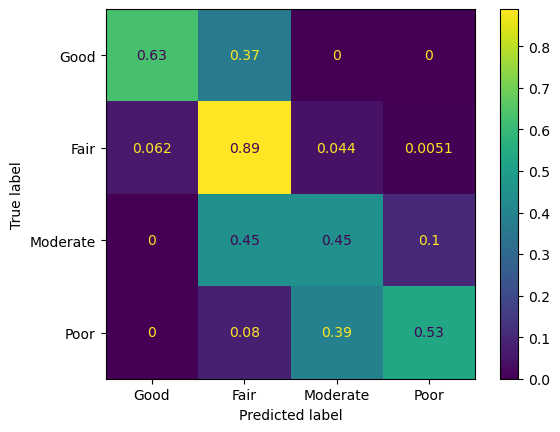

In [77]:
'Evaluate model with test data'
y_predict=model.predict(X_test).argmax(axis=1)
y_predict_cat=pd.Series(y_predict).map(aqi_labels)
y_test_cat=pd.Series(y_test).map(aqi_labels)

'Test Score'
print("Test Score of the Models")
accuracy_test=metrics.accuracy_score(y_test,y_predict)
print(f"score of the model: {round(accuracy_test,5)}")
balanced_accuracy_test=metrics.balanced_accuracy_score(y_test,y_predict)
print(f"balanced score of the model: {round(balanced_accuracy_test,5)}")
f1_test=metrics.f1_score(y_test,y_predict,average="weighted")
print(f"f1 score of the model: {round(f1_test,5)}")

cm=metrics.confusion_matrix(y_true=y_test_cat,y_pred=y_predict_cat,labels=list(aqi_labels.values()),normalize="true")
disp = metrics.ConfusionMatrixDisplay(cm,display_labels=list(aqi_labels.values()))

disp.plot()

Text(0.5, 1.0, 'Verlauf der Metriken nach jedem Traininsschritt')

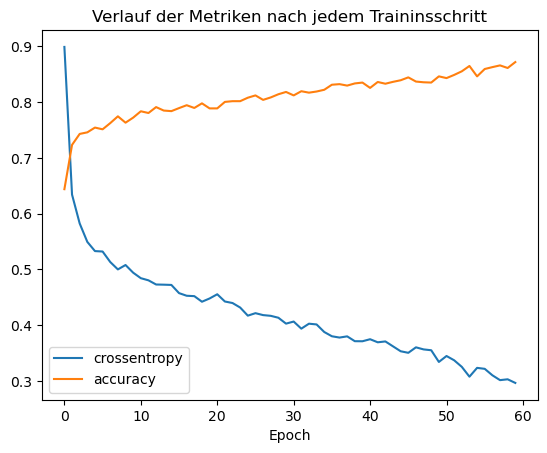

In [80]:
'Verlauf der Metriken nach jedem Traininsschritt'
plt.plot(hist.history["sparse_categorical_crossentropy"],label="crossentropy")
plt.plot(hist.history["accuracy"],label="accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.title("Verlauf der Metriken nach jedem Traininsschritt")

Schlussendlich überzeugt hier in diesem Beispiel die Performance des neuronalen Netzes wenig im Vergleich zum GBC von AQI_NO2: 
- Training dauert länger
- f1_score und score sind schlechter
- auch mehr Training ändert daran wenig -> führt dann nur zu Overfitting
- ebenso wie mehr Layer (also mehr Parameter)
Allerdings wurde hier auch keine Suche nach den besten Hyperparametern des Modells gemacht und mit den Parametern des neuronalen Netzes kennen ich mich nur sehr wenig aus. 